# CAR PRICING MODEL
by Alfonso Cervantes Barragán   
By any questions or recommendation contact me: email a.cervantes2012@hotmail.com

## Table of Contents

1. [Problem](#problem)
2. [Objective](#objective)
3. [Proposed solution](#proposed_solution)  
   [Adjusted price strategy](#adjusted_strategy)
4. [Data preprocessing](#data_preprocesing)  
   [Description of dataset](#description_dataset)  
   [Handling of missing values](#missing_values)   
   [Removing columns](#removing_columns)  
   [Variable Vin](#variable_vin)
   [Variable price](#handling_prince)  
   [Variable odometer](#handling_odometer)   
   [Variable condition](#handling_condition)  
   [Imbalance inside cathegorical variable](#imbalance)  
   [Feature engineering](#feature_engineering)  
   [Variable odometer](#odometer_cathegorical)
5. [Data analysis](#data_analysis)  
   [Discriminatory power of the variables](#discriminatory_power)
6. [Modeling](#modeling)  
   [model lightgbm](#lightgbm)     
   [Hyperparameter tunning](#grid_search)    
   [Results](#results)    
   [Actual vs predicted prices](#actual_vs_predicted)    
     [Distribution of residuals](#residuals)  
            [Adjustment of prices based on adjusted price strategy](#adjusted_prices_model)
                [Change in profit and loss](#profit_loss)    
                [Change in probability of saling](#pro_of_saling)
7. [Question Asigned](#asigned_question)  
        [Variable odometer](#variable_odometer_a)  
        [Variable condition](#variable_condition_a)  
        [Variable_vin](#variable_vin_a)    
        [Variable price](#variable_price_a)  
        [About the model](#model_a)  


     
   
## PROBLEM  <a name="problem"></a>

The Innovation and Sales departments aim to modernize operations by reducing friction in the sales process. To achieve this, you suggest developing a model to automatically price cars, enabling potential customers to engage in a self-service purchasing process online or in-store. 

The task involves constructing this model using available datasets: "vehicles.csv," "crashes_poverty.csv," and "counties.csv."



## Objective  <a name="objective"></a>

A pricing model should be built that predicts the optimal price for
each car to maximize profits while maintaining a high likelihood of closing sales.

## Proposed solution <a name="proposed_solution">

### Adjusted Price Strategy <a name="adjusted_strategy">

An adjusted pricing strategy is a dynamic approach to setting the advertised price of products or services, which considers various factors such as market conditions, competitor strategies, customer preferences, and economic indicators.  

The primary objective is twofold: to boost profitability and market share by establishing prices that are perceived as fair and competitive, while aligning with the company's goals. This strategy entails continuously adapting prices based on the probability of making a sale, aiming to strike a delicate balance between maximizing revenue and ensuring a favorable likelihood of transaction completion.

Advantages of the Adjusted Price Strategy:
- **Maximized Profits**: By pricing products slightly above market value, the strategy enables the dealership to capture additional value on each sale.
- **High Likelihood of Selling**: Adjusting prices based on the probability of selling ensures that products remain appealing to potential buyers, resulting in increased sales volume.
- **Competitive Advantage**: Adjusted prices strike a balance between profitability and competitiveness, providing the dealership with an advantageous position in the market.
- **Adaptability**: The strategy is flexible and adaptable to changing market dynamics and customer preferences, allowing for responsive pricing decisions.

**Steps for the implementation of the Adjusted Price Strategy:**

1. **Predictive Model Selection**:
   - The strategy begins with the selection of an appropriate predictive model,which can capture complex relationships
between car features and prices. 

2. **Market Value Consideration**:
   - Before adjusting the predicted price, the model takes into account the market value of the car. The market value serves as a benchmark against which the predicted price is compared.

3. **Calculation of Overcharge Ratio**:
   - The overcharge ratio is calculated by dividing the predicted price by the market value and subtracting 1. This ratio indicates how much the predicted price exceeds the market value, if at all.
   
   $$overcharge \: = \frac{predicted \: price}{market \: value} - 1 $$
   
4. **Probability of Selling**:
   - The overcharge ratio is then used to calculate the probability of selling the car. This probability represents the likelihood that the car will be sold at the predicted price, considering the extent to which it exceeds  the market value.   - The probability of selling is calculated as the difference between 1 and the minimum of 1 and the overcharge ratio. 
   
   $$P(predicted \: price |market \: value) = 1 - min(1, overcharge \: ratio) $$
   

5. **Adjustment Based on Probability Threshold**:
   - Next, the strategy defines a probability threshold, representing the minimum acceptable probability of selling. This threshold is set based on business objectives and market dynamics.
   - If the overcharge ratio is positive (indicating the predicted price is higher than the market value) and the probability of selling exceeds the threshold, the price is adjusted.
   - The adjusted price is calculated by multiplying the predicted price by the probability of selling. This adjustment ensures that the price remains attractive enough to maintain a high likelihood of selling while still maximizing profitability.
   
   $$Adjusted \: price = Predicted \: price \times P(predicted \: price | market \: value) $$




### Intalling libraries

In [392]:
#installing module "xgboost"
#!pip install xgboost

#installing module "lightgbm"
#!pip install lightgbm

### Loading libraries

In [393]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost as xgb
import lightgbm as lgb

import regex as re
from unidecode import unidecode

### DATA PREPROCESSING   <a name="data_preprocessing">


#### Load datasets

In [394]:
# Load datasets
vehicles_df = pd.read_csv('vehicles.csv')


The datasets "county.csv" and "crashes_poverty.csv" will be excluded from consideration for the car pricing objective as I believe their information is unrelated. "county.csv" solely contains a mapping between state names and their abbreviations, which is not pertinent to determining car prices. Similarly, "crashes_poverty.csv" includes variables such as "Number of crashes" and "Poverty," which are deemed irrelevant for car pricing since they do not provide insight into the condition of the vehicles.

#### Description of dataset <a name="description_dataset">

**Vehicles dataset**

This dataset serves the purpose of providing information about used cars available for sale or listing, including various attributes and details to help potential buyers make informed decisions.

In [395]:
print("Number of rows ", vehicles_df.shape[0])
print("Number of columns ", vehicles_df.shape[1])


Number of rows  26988
Number of columns  21


Here's a breakdown of what each column likely represents:

- **region**: The geographical region or area where the car is being sold or listed (string)
- **price**: The price of the car. (integer)
- **year**: The year the car was manufactured.(integer)
- **manufacturer**: The company that manufactured the car. (string)
- **model**: The specific model of the car. (string)
- **condition**: The condition of the car (excellent', 'good', 'like new', 'fair', 'new', 'salvage'). (string)
- **cylinders**: The number of cylinders in the car's engine. (string)
- **fuel**: The type of fuel the car uses (e.g., gasoline, diesel, electric, etc.). (string)
- **odometer**: The mileage or distance traveled by the car. (float)
- **title_status**: The status of the car's title . (string)
- **transmission**: The type of transmission in the car ('automatic', 'manual', 'other'). (string)
- **vin**: The Vehicle Identification Number, a unique code assigned to each vehicle. (string)
- **drive**: The drive type of the car (front-wheel drive (fwd), rear-wheel drive (rwd), 4wd). (string)
- **size**: The size category of the car ('mid-size', 'compact', 'full-size', 'sub-compact'). (string)
- **type**: The type of body style of the car ('wagon', 'pickup', 'sedan', 'coupe', 'van', 'mini-van', 'SUV',
       'truck', 'other', 'hatchback', 'convertible', 'bus', 'offroad'). (string)
- **paint_color**: The color of the car's exterior paint ('white', 'red', 'silver', 'grey', 'black', 'blue', 'brown',
       'custom', 'purple', 'green', 'yellow', 'orange').(string)
- **description**: Additional description or details about the car. (string)
- **county**: The county where the car is located.
- **state**: The state where the car is located. (string)
- **lat**: The latitude coordinates of the car's location. (float)
- **long**: The longitude coordinates of the car's location. (float)


### Handling of missing values  <a name="missing_values">

Calculating percentage of missing values per column

In [396]:
vehicles_df.isnull().sum()*100/vehicles_df.shape[0]

region            0.000000
price             0.000000
year              0.185268
manufacturer      4.424189
model             1.567363
condition        43.145102
cylinders        41.892693
fuel              0.622499
odometer         18.508226
title_status      0.507633
transmission      0.874463
vin              40.284571
drive            29.627983
size             69.075145
type             26.534015
paint_color      32.570031
description       0.011116
county          100.000000
state             0.000000
lat               1.330221
long              1.330221
dtype: float64

**Visualizing degree of missing values across the dataset**

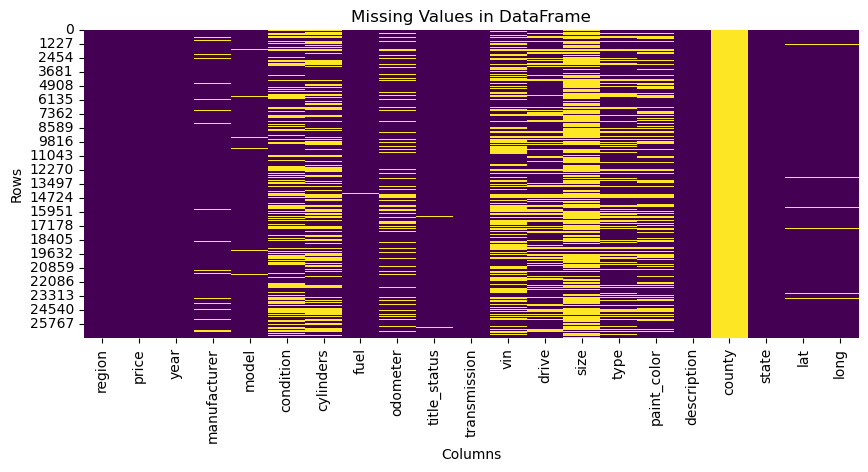

In [397]:
plt.figure(figsize=(10, 4))
sns.heatmap(vehicles_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

**Level of dataset corruption**  

Ratio between the number of fields in the dataset containing missing values and the total number of fields in the dataset.

In [398]:
per=vehicles_df.isnull().sum().sum()*100/(vehicles_df.shape[0]*vehicles_df.shape[1])
print("The level of corruption is ", per, " %")

The level of corruption is  19.642416029699266  %


**Conclusiones:**

1. Year, Fuel, Title_status, Transmission, Description, Model, Latitude,Longitude and Manufacturer: The missing values for this columns are relatively low (< 5%).

2. Odometer, Drive, Type and Paint Color: These columns have a moderate percentage of missing values, ranging from 18.5% to 32.57%. Missing values in these columns may impact analysis and decision-making.

3. VIN, Conditions, Cylinders: The missing values are notably high with percentage range between 40% and 43%.

4. Size: The missing values are extrem high with percentage of 69%, with a vast majority of entries lacking this information. Therefore, the column will be removed. 

5. county: does not contain any concrete data. Therefore, the column will be removed.

6. Around 20% of the fields in a dataset contain missing values.This result suggests a notable level of incompleteness in the data. This proportion of missing values may impact the reliability and accuracy of analyses conducted on the dataset.

In summary, the presence of missing values poses significant challenges to the accuracy and reliability of results. Therefore, it's crucial to adopt appropriate techniques such as imputation or exclusion to manage these missing values effectively.

#### Removing columns  <a name="removing_columns"></a>

**Columns "county" and "size"**

Due to the high degree of missing values corresponding to percentages greater than 69%, the columns will be removed.

In [399]:
vehicles_df.drop(columns=["county","size"], inplace=True)

**Columns "Latitude" and "Longitude"**  

Although the level of missing values of this variables is not very high, Latitude and longitude coordinates represent geographic location, which is already indicated through the columns State and region. Including latitude and longitude as predictor variables might not provide meaningful insights for price prediction.

In [400]:
vehicles_df.drop(columns=["lat","long"],inplace=True)

**Removing the column "description"** 

Removing car descriptions from a pricing prediction dataset is justified due to their unstructured nature and subjectivity. Including descriptions increases dimensionality, complicates data preprocessing, and may not improve model accuracy. By removing them, the dataset becomes more streamlined.

In [401]:
vehicles_df.drop(columns=["description"],inplace=True)

**Variable VIN** <a name="handling_of_vin"></a>

**Handling of duplicated rows according to the VIN**

In [402]:
duplicate_rows = vehicles_df[(vehicles_df.vin.duplicated()) & (vehicles_df.vin.notnull())]
print("Number of duplicated VIN", duplicate_rows.shape[0])

Number of duplicated VIN 1307


**Removing duplicate rows**

In [403]:
vehicles_df1 = vehicles_df[~vehicles_df.index.isin(duplicate_rows.index)].copy()
print("number of rows remaining ", vehicles_df1.shape[0])

number of rows remaining  25681


**Removing column "vin"**

In [404]:
vehicles_df1.drop(columns=["vin"],inplace=True)

Reason for removing the Vehicle Identification Number (VIN):  

1. Uniqueness: VINs are unique identifiers assigned to individual vehicles. Including VINs in the dataset does not provide meaningful information for predicting car prices because each VIN corresponds to a specific car and does not contain inherent characteristics related to price prediction.  
2. Non-predictive: VINs are not predictive of car prices themselves. While VINs are essential for purposes such as vehicle registration and tracking, they do not directly influence the price of a car. 

**Removing columns "region"**

The decision to exclude the variable "region" is guided by the specific goals of the model. In this context, the aim is to precisely forecast prices across diverse regulatory landscapes, rather than emphasizing capturing general market trends, which can be highly variable over time. Moreover, incorporating both "state" and "region" could significantly escalate the complexity of the model, potentially complicating interpretation and diminishing its practical utility.

In [405]:
vehicles_df1.drop(columns=["region"],inplace=True)

**Handling of missing values in column "title_status"**  

The "title_status" column is categorical and comprises five distinct categories, as mentioned earlier. Given that the "clean" category represents approximately 95% of all assignments, it will serve as the basis for imputing missing values.

Distribution of each category in the dataset

In [406]:
vehicles_df1.title_status.value_counts()/vehicles_df1[vehicles_df1.title_status.notnull()].shape[0]

title_status
clean         0.957061
rebuilt       0.022076
salvage       0.013543
lien          0.005597
missing       0.001213
parts only    0.000509
Name: count, dtype: float64

In [407]:
vehicles_df1.title_status.fillna(vehicles_df1.title_status.mode().iloc[0], inplace=True)

Number of remaining missing values

In [408]:
vehicles_df1.title_status.isnull().sum()

0

**Handling missing values of "year"**  

In [409]:
per = vehicles_df1[vehicles_df1.year.isnull()].shape[0]*100/vehicles_df1.shape[0]
print("El porcentaje de missing values of the variable 'year' is ", round(per,2), " %")

El porcentaje de missing values of the variable 'year' is  0.17  %


Text(0.5, 0, 'year')

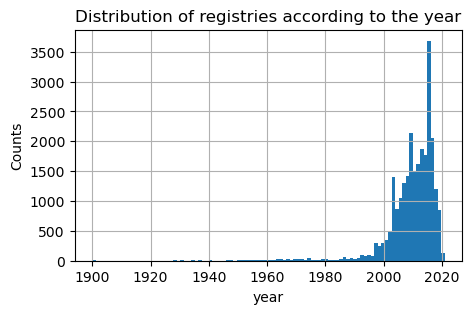

In [410]:
plt.figure(figsize=(5,3))
plt.title("Distribution of registries according to the year")
vehicles_df1.year.hist(bins=100)
plt.ylabel("Counts")
plt.xlabel("year")


Due to the distribution of data clustering around a central value and the small proportion of missing values, utilizing the mode as an imputation strategy is appropriate.

In [411]:
mode_value = vehicles_df1['year'].mode()[0]  
vehicles_df1['year'].fillna(mode_value, inplace=True)

Number of remaining missing values

In [412]:
vehicles_df1.year.isnull().sum()

0

**Handling missing values of "transmission"**  

In [413]:
per = vehicles_df1[vehicles_df1.transmission.isnull()].shape[0]*100/vehicles_df1.shape[0]
print("El porcentaje de missing values of the variable 'transmission' is ", round(per,2), " %")

El porcentaje de missing values of the variable 'transmission' is  0.84  %


The column "transmission" is cathegorical containing the following categories and distribution

In [414]:
vehicles_df1.transmission.value_counts()/vehicles_df1.shape[0]

transmission
automatic    0.878432
manual       0.066547
other        0.046649
Name: count, dtype: float64

Given that approximately 87% of vehicles have automatic transmission, and considering the low occurrence of missing values, the automatic transmission will be used as the imputation value.

In [415]:
mode_value = vehicles_df1['transmission'].mode()[0]  
vehicles_df1['transmission'].fillna(mode_value, inplace=True)

Number of remaining missing values

In [416]:
vehicles_df1.transmission.isnull().sum()

0

**Handling missing values of "fuel"**  

In [417]:
per = vehicles_df1[vehicles_df1.fuel.isnull()].shape[0]*100/vehicles_df1.shape[0]
print("El porcentaje de missing values of the variable 'transmission' is ", round(per,2), " %")

El porcentaje de missing values of the variable 'transmission' is  0.63  %


The column "transmission" is cathegorical containing the following categories and distribution

In [418]:
vehicles_df1.fuel.value_counts()/vehicles_df1.shape[0]

fuel
gas         0.871033
diesel      0.077256
other       0.033488
hybrid      0.009462
electric    0.002453
Name: count, dtype: float64

Given that approximately 87% of vehicles have gas fuel, and considering the low occurrence of missing values, the gas fuel will be used as the imputation value.

In [419]:
mode_value = vehicles_df1['fuel'].mode()[0]  
vehicles_df1['fuel'].fillna(mode_value, inplace=True)

Number of remaining missing values

In [420]:
vehicles_df1.fuel.isnull().sum()

0

**Handling outliers and missing values for the variable 'price'** <a name="handling_price"></a>

There is no missing values

Statistics

In [421]:
vehicles_df1.price.describe()

count    2.568100e+04
mean     5.704890e+04
std      6.966621e+06
min      0.000000e+00
25%      4.250000e+03
50%      9.500000e+03
75%      1.740000e+04
max      1.116081e+09
Name: price, dtype: float64

The dataset of car prices presents a wide range of values, with an average price of around 55,116. The standard deviation of approximately 6,795,834 indicates considerable variability, suggesting that prices are spread out from this average. While most cars are priced within a reasonable range, there are some outliers, as evidenced by the minimum price of 0,0  and the maximum price of approximately 1,116,081,000.  Additionally, the quartile analysis reveals that  three-quarters are priced below 17,900  providing further insights into the distribution of prices among the listed cars.

On the other side, 25% of the values are below 4,250. 

Distribution of car prices below the 25 percentil

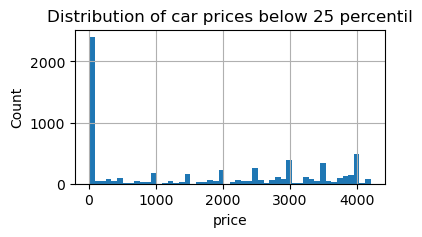

In [422]:
plt.figure(figsize=(4,2))
plt.title("Distribution of car prices below 25 percentil")
vehicles_df1[vehicles_df1.price < 4250].price.hist(bins=50)
plt.ylabel("Count")
plt.xlabel("price")
plt.show()

The legal minimum value for a car sale can vary significantly depending on local laws and regulations. In some jurisdictions, there may not be a specific legal minimum value for car sales, but there are laws governing 
fair and transparent transactions.For example, in some areas, there may be laws governing the
sale of used cars to prevent predatory pricing or unfair practices. These laws might
set a minimum price that dealerships or private sellers must adhere to when selling a vehicle.

source: https://www.federalregister.gov/documents/2022/07/13/2022-14214/motor-vehicle-dealers-trade-regulation-rule

Percentage of registries without a price (=0 or nan)

In [423]:
print(vehicles_df1[(vehicles_df1.price == 0) | (vehicles_df1.price.isnull())].shape[0]*100/vehicles_df1.shape[0], " %")


8.496553872512752  %


Percentage of registries below 1,000 price, but not zero.

In [424]:
print(vehicles_df1[vehicles_df1.price < 1000].shape[0]*100/vehicles_df1.shape[0] - 8.49655, " %")

2.7685876504030222  %


The number of registries without price is very high corresponding to a 8.49% of the total amount. The general choice 
to avoid loss of information is to imput the variable, but some disadvantages can be drawn:

1. **Bias Introduction**: Imputing missing values in the target variable using other variables or its distribution can introduce bias into the model, potentially leading to inaccurate predictions.

2. **Overfitting**: especially if the imputation method is complex or relies heavily on other variables, reducing the model's generalization ability to unseen data.

3. **Data Leakage**: the usage of information from other variables can result in data leakage. Data leakage occurs when information from the training data is inadvertently incorporated into the model, leading to inflated performance metrics during training but poor generalization to new data.

4. **Reduced Model Interpretability**: because it becomes challenging to explain the relationship between the predictor variables and the target variable when the target variable's values are artificially modified.

5. **Loss of Information**: If the missing values contain meaningful patterns or insights, imputing them may obscure important trends or relationships in the data.

On the other side, there is not much real to have pricing below 1,000, which it will be assumed to be a minimum legal price for a car. 


Therefore, in this particular case removing rows with missing prices may be preferable to imputing values 
because they represent a significant portion of the dataset and  imputation  may introduce bias or inaccuracies
into the model





In [425]:
vehicles_df2 = vehicles_df1[(vehicles_df1.price >= 1000)].copy()

Removing outliers of variable price with the IQR method

There are three reasons considered important for removing outliers in this case:

1. To maintain model performance in order to improve the robustness and generalization ability of the predictive model.
2. To maintain the assumption of normality: mMany statistical methods and machine learning algorithms assume that the target variable follows a normal distribution or at least does not contain extreme values that violate model assumptions. Removing outliers can help satisfy these assumptions and improve the validity of statistical tests and model interpretations.

In [426]:
Q1 = vehicles_df2["price"].quantile(0.25)
Q3 = vehicles_df2["price"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
print("lower bound ", lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("upper bound ", upper_bound)


# Filter the DataFrame for outliers
outliers = vehicles_df2[(vehicles_df2["price"] < lower_bound) | (vehicles_df2["price"] > upper_bound)]

# Print or use the 'outliers' DataFrame to further analyze or handle the outliers
print("number of outliers ", outliers.shape[0], " corresponding to a percentage of ", outliers.shape[0]*100/vehicles_df2.shape[0], " %")

lower bound  -13030.0
upper bound  37578.0
number of outliers  862  corresponding to a percentage of  3.782692645251887  %


Filtering out outliers

In [427]:
vehicles_df2 = vehicles_df2[(vehicles_df2["price"] >= lower_bound) & (vehicles_df2["price"] <= upper_bound)]

Validating the new distribution

In [428]:
vehicles_df2.price.describe()

count    21926.000000
mean     12493.714357
std       8362.596624
min       1000.000000
25%       5800.000000
50%      10500.000000
75%      17500.000000
max      37550.000000
Name: price, dtype: float64

Visualization new distribution of prices

Text(0.5, 0, 'Price')

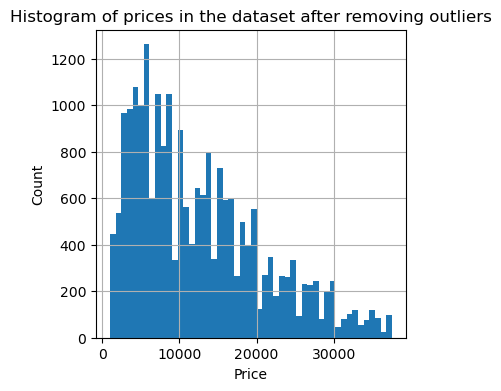

In [429]:
plt.figure(figsize=(4,4))
plt.title("Histogram of prices in the dataset after removing outliers")
vehicles_df2.price.hist(bins=50)
plt.ylabel("Count")
plt.xlabel("Price")

**Missing values with the variable "cylinder"**

In [430]:
vehicles_df2.cylinders.value_counts()

cylinders
6 cylinders     4694
4 cylinders     4219
8 cylinders     3938
5 cylinders      121
10 cylinders      62
3 cylinders       35
other             34
12 cylinders       7
Name: count, dtype: int64

**Imputation of cylinder labels based on the most common cylinder type per manufacturer**

We will establish a mapping relationship between manufacturers and cylinder types, and then assign the most common cylinder type corresponding to each manufacturer to the cylinder field if it is NaN, based on the manufacturer assigned.

In [431]:
# Grouping by manufacturer and cylinders. Count the number of registries
df102 = vehicles_df2.groupby(["manufacturer","cylinders"])["state"].count().reset_index()

# Group by manufaturer and extract the maximum value of the subgroup
max_values = df102.groupby(["manufacturer"])["state"].transform("max")

# Filter the data according to the max values
result = df102[df102['state'] == max_values]

# Build a dictionary containing manufacturer and cylinders.
manufacturer_dict = result.set_index('manufacturer')['cylinders'].to_dict()

print(manufacturer_dict)

{'acura': '6 cylinders', 'alfa-romeo': '4 cylinders', 'audi': '4 cylinders', 'bmw': '6 cylinders', 'buick': '6 cylinders', 'cadillac': '8 cylinders', 'chevrolet': '8 cylinders', 'chrysler': '6 cylinders', 'datsun': '6 cylinders', 'dodge': '6 cylinders', 'fiat': '4 cylinders', 'ford': '8 cylinders', 'gmc': '8 cylinders', 'harley-davidson': '8 cylinders', 'honda': '4 cylinders', 'hyundai': '4 cylinders', 'infiniti': '6 cylinders', 'jaguar': '8 cylinders', 'jeep': '6 cylinders', 'kia': '4 cylinders', 'land rover': '8 cylinders', 'lexus': '6 cylinders', 'lincoln': '6 cylinders', 'mazda': '4 cylinders', 'mercedes-benz': '6 cylinders', 'mercury': '8 cylinders', 'mini': '4 cylinders', 'mitsubishi': '4 cylinders', 'nissan': '4 cylinders', 'pontiac': '6 cylinders', 'porche': '8 cylinders', 'ram': '8 cylinders', 'rover': '8 cylinders', 'saturn': '6 cylinders', 'subaru': '4 cylinders', 'toyota': '4 cylinders', 'volkswagen': '4 cylinders', 'volvo': '5 cylinders'}


To evoid conflict with nan values, convert them to empty strings

In [432]:
vehicles_df2.cylinders.fillna("",inplace=True)

Function which asigns cylinder type according to the manufacturar

In [433]:
def asigncylinder(dict_,x, reference, target):
    
    #dict_ = dictionary : mapping between manufacturer and cylinder type
    #x     : current row of the dataset.
    #reference : reference variable as guide
    #target  : target variable which will be imputed.
    
    refvar = x[reference]
    targetvar = x[target]
    
    # if cylinder field is empty
    if targetvar == "":
        
        if refvar in dict_.keys():
            return dict_[refvar]
        else:
            #if referene is not defined in dictionary, classifies it as "NaN"
            return pd.NA
    else:
    # if not, return the current value
        return targetvar

Imputation of missing value in column "cylinders"

In [434]:
vehicles_df3 = vehicles_df2.copy()
vehicles_df3["cylinders"] = vehicles_df3.apply(lambda x: asigncylinder(manufacturer_dict,x,"manufacturer","cylinders"),axis=1)

Number of fields which could not be imputed

In [435]:
vehicles_df3.cylinders.isnull().sum()

322

Using the mode to complete imputation

In [436]:
mode_value = vehicles_df3['cylinders'].mode()[0]  
vehicles_df3['cylinders'].fillna(mode_value, inplace=True)

Number of remaining missing values

In [437]:
vehicles_df3.cylinders.isnull().sum()

0

**Handling of missing values in column "type"**

In [438]:
vehicles_df3.type.value_counts()

type
sedan          4110
SUV            3773
pickup         2170
truck          1763
coupe           944
other           751
hatchback       712
wagon           500
van             466
convertible     408
mini-van        281
offroad          40
bus              22
Name: count, dtype: int64

**Imputation of type labels based on the most common type per manufacturer**

A mapping relationship will be established between manufacturers and types, and then assign the most common type corresponding to each manufacturer to the type field if it is NaN, based on the manufacturer assigned.

In [439]:
# Grouping by manufacturer and cylinders. Count the number of registries
df102 = vehicles_df3.groupby(["manufacturer","type"])["state"].count().reset_index()

# Group by manufaturer and extract the maximum value of the subgroup
max_values = df102.groupby(["manufacturer"])["state"].transform("max")

# Filter the data according to the max values
result = df102[df102['state'] == max_values]

# Build a dictionary containing manufacturer and cylinders.
manufacturer_dict = result.set_index('manufacturer')['type'].to_dict()

print(manufacturer_dict)


{'acura': 'sedan', 'alfa-romeo': 'convertible', 'audi': 'sedan', 'bmw': 'sedan', 'buick': 'sedan', 'cadillac': 'sedan', 'chevrolet': 'pickup', 'chrysler': 'sedan', 'datsun': 'other', 'dodge': 'sedan', 'fiat': 'hatchback', 'ford': 'pickup', 'gmc': 'SUV', 'harley-davidson': 'pickup', 'honda': 'sedan', 'hyundai': 'sedan', 'infiniti': 'sedan', 'jaguar': 'sedan', 'jeep': 'SUV', 'kia': 'sedan', 'land rover': 'SUV', 'lexus': 'sedan', 'lincoln': 'sedan', 'mazda': 'sedan', 'mercedes-benz': 'sedan', 'mercury': 'sedan', 'mini': 'hatchback', 'mitsubishi': 'sedan', 'nissan': 'sedan', 'pontiac': 'sedan', 'porche': 'coupe', 'ram': 'pickup', 'rover': 'SUV', 'saturn': 'sedan', 'subaru': 'wagon', 'tesla': 'sedan', 'toyota': 'sedan', 'volkswagen': 'sedan', 'volvo': 'sedan'}


To evoid conflict with nan values, convert them to empty strings

In [440]:
vehicles_df3.type.fillna("",inplace=True)

Imputation of missing value in column "type"

In [441]:
vehicles_df4 = vehicles_df3.copy()
vehicles_df4["type"] = vehicles_df4.apply(lambda x: asigncylinder(manufacturer_dict,x,"manufacturer","type"),axis=1)

In [442]:
missval = vehicles_df4.type.isnull().sum()
print("Number of remaining missing values ", missval)

Number of remaining missing values  318


Using the mode to complete imputation

In [443]:
mode_value = vehicles_df4['type'].mode()[0]  
vehicles_df4['type'].fillna(mode_value, inplace=True)

**Handling of missing values in column "drive"**

In [444]:
vehicles_df4.drive.value_counts()

drive
4wd    6268
fwd    5821
rwd    3301
Name: count, dtype: int64

**Imputation of type labels based on the most common drive per manufacturer**

A mapping relationship will be established between manufacturers and drive, and then assign the most common drive corresponding to each manufacturer to the drive field if it is NaN, based on the manufacturer assigned.

In [445]:
# Grouping by manufacturer and cylinders. Count the number of registries
df102 = vehicles_df4.groupby(["manufacturer","drive"])["state"].count().reset_index()

# Group by manufaturer and extract the maximum value of the subgroup
max_values = df102.groupby(["manufacturer"])["state"].transform("max")

# Filter the data according to the max values
result = df102[df102['state'] == max_values]

# Build a dictionary containing manufacturer and cylinders.
manufacturer_dict = result.set_index('manufacturer')['drive'].to_dict()

print(manufacturer_dict)
#df102.head(20)

{'acura': 'fwd', 'alfa-romeo': 'rwd', 'audi': '4wd', 'bmw': 'rwd', 'buick': 'fwd', 'cadillac': 'fwd', 'chevrolet': '4wd', 'chrysler': 'fwd', 'datsun': 'rwd', 'dodge': 'fwd', 'fiat': 'fwd', 'ford': '4wd', 'gmc': '4wd', 'honda': 'fwd', 'hyundai': 'fwd', 'infiniti': 'rwd', 'jaguar': 'rwd', 'jeep': '4wd', 'kia': 'fwd', 'land rover': '4wd', 'lexus': 'fwd', 'lincoln': 'fwd', 'mazda': 'fwd', 'mercedes-benz': 'rwd', 'mercury': 'rwd', 'mini': 'fwd', 'mitsubishi': 'fwd', 'nissan': 'fwd', 'pontiac': 'fwd', 'porche': '4wd', 'ram': '4wd', 'rover': '4wd', 'saturn': 'fwd', 'subaru': '4wd', 'tesla': 'rwd', 'toyota': 'fwd', 'volkswagen': 'fwd', 'volvo': 'fwd'}


To evoid conflict with nan values, convert them to empty strings

In [446]:
vehicles_df4.drive.fillna("",inplace=True)

Imputation of missing value in column "drive"

In [447]:
vehicles_df5 = vehicles_df4.copy()
vehicles_df5["drive"] = vehicles_df5.apply(lambda x: asigncylinder(manufacturer_dict,x,"manufacturer","drive"),axis=1)

number of missing values which could not be imputed

In [448]:
vehicles_df5.drive.isnull().sum()

347

Using the mode to complate imputation

In [449]:
mode_value = vehicles_df5['drive'].mode()[0]  
vehicles_df5['drive'].fillna(mode_value, inplace=True)

In [450]:
vehicles_df5.drive.isnull().sum()

0

**Handling missing values for the variable odometer**  <a name="handling_odometer"></a>

Statistics of the variable "odometer"

In [451]:
vehicles_df5.odometer.describe()

count    1.786900e+04
mean     1.039202e+05
std      1.177253e+05
min      0.000000e+00
25%      5.200000e+04
50%      9.630100e+04
75%      1.400000e+05
max      9.999999e+06
Name: odometer, dtype: float64

According to distribution of the variable "odometer", it seems that the data may be positively skewed, 
given that the mean is larger than the median and is influenced by outliers. 

Visualization of the distribution of the variable "odometer"

Text(0.5, 1.0, "Histrogram based on the variable 'odometer'")

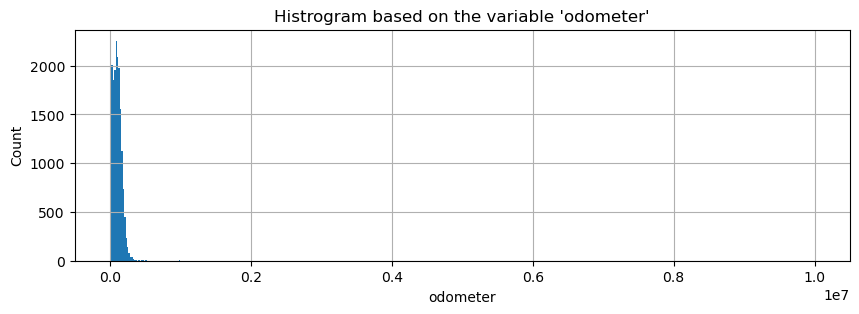

In [452]:
plt.figure(figsize=(10,3))
vehicles_df5.odometer.hist(bins=500)
plt.ylabel("Count")
plt.xlabel("odometer")
plt.title("Histrogram based on the variable 'odometer'")

**Imputation with the median**

It is advisable in situations where the data is skewed or contains outliers, making the mean less representative of the central tendency. The median, being the middle value when the data is sorted, is robust to outliers and provides a more accurate estimate of the central tendency in such cases. 

In [453]:
vehicles_df5.odometer.fillna(vehicles_df5.odometer.median(),inplace=True)

**Handling missing values for the variable paint_color**

In [454]:
vehicles_df6 = vehicles_df5.copy()

In [455]:
vehicles_df6.paint_color.value_counts()

paint_color
white     3978
black     2872
silver    2266
red       1491
grey      1489
blue      1484
green      406
custom     360
brown      343
yellow     110
orange      93
purple      31
Name: count, dtype: int64

**Imputation of type labels based on the most common paint color per manufacturer**

A mapping relationship will be established between manufacturers and the color of the car, and then assign
the most common color of the car corresponding to each manufacturer to the paint_color field if it is NaN, 
based on the manufacturer assigned.

In [456]:
# Grouping by manufacturer and cylinders. Count the number of registries
df102 = vehicles_df6.groupby(["manufacturer","paint_color"])["state"].count().reset_index()

# Group by manufaturer and extract the maximum value of the subgroup
max_values = df102.groupby(["manufacturer"])["state"].transform("max")

# Filter the data according to the max values
result = df102[df102['state'] == max_values]

# Build a dictionary containing manufacturer and cylinders.
manufacturer_dict = result.set_index('manufacturer')['paint_color'].to_dict()

print(manufacturer_dict)
#df102.head(20)

{'acura': 'black', 'alfa-romeo': 'red', 'audi': 'black', 'bmw': 'black', 'buick': 'white', 'cadillac': 'black', 'chevrolet': 'white', 'chrysler': 'white', 'datsun': 'yellow', 'dodge': 'white', 'fiat': 'black', 'ford': 'white', 'gmc': 'white', 'harley-davidson': 'black', 'honda': 'silver', 'hyundai': 'silver', 'infiniti': 'black', 'jaguar': 'black', 'jeep': 'black', 'kia': 'white', 'land rover': 'green', 'lexus': 'silver', 'lincoln': 'white', 'mazda': 'black', 'mercedes-benz': 'black', 'mercury': 'white', 'mini': 'grey', 'mitsubishi': 'white', 'nissan': 'white', 'pontiac': 'black', 'porche': 'white', 'ram': 'white', 'rover': 'black', 'saturn': 'silver', 'subaru': 'blue', 'tesla': 'blue', 'toyota': 'white', 'volkswagen': 'black', 'volvo': 'white'}


To evoid conflict with nan values, convert them to empty strings

In [457]:
vehicles_df6.paint_color.fillna("",inplace=True)

Imputation of missing value in column "paint_color"

In [458]:
vehicles_df6["paint_color"] = vehicles_df6.apply(lambda x: asigncylinder(manufacturer_dict,x,"manufacturer","paint_color"),axis=1)

Number of missing values which could not be imputed

In [459]:
vehicles_df6.paint_color.isnull().sum()

323

Using the mode to complete imputation

In [460]:
mode_value = vehicles_df6['paint_color'].mode()[0]  
vehicles_df6['paint_color'].fillna(mode_value, inplace=True)

In [461]:
vehicles_df6.paint_color.isnull().sum()

0

**Handling missing values for the variable condition** <a name="handling_condition"></a>

In [462]:
vehicles_df7 = vehicles_df6.copy()

In [463]:
print("missing value percentage ", vehicles_df7.condition.isnull().sum()*100/vehicles_df7.shape[0], " %")

missing value percentage  40.226215451974824  %


Distribution of the categories belonging to the variable "condition"

In [464]:
vehicles_df7.condition.value_counts()

condition
excellent    6138
good         5276
like new     1280
fair          345
new            37
salvage        30
Name: count, dtype: int64

**Relationship among different categories**

While "excellent," "good," and "like new" all indicate a certain level of quality, they differ in the degree of wear and tear they suggest. "Excellent" implies top-tier condition, "good" suggests acceptable condition with some signs of use, and "like new" emphasizes a premium quality comparable to a brand-new vehicle.

Therefore, to assign values to missing data, the categories will be grouped as follows:

1. "Excellent" and "good" as "good condition" (most frequent categorie)
2. "Like new" and "new" as "like new or new"
3. "Fair"
4. "Salvage"

Imputation with the mode

In [465]:
vehicles_df7.condition.fillna(" ",inplace=True)

In [466]:
condition_dict = dict()
condition_dict["excellent"] = "Good condition"
condition_dict["good"] = "Good condition"
condition_dict["like new"] = "like new or new"
condition_dict["new"] = "like new or new"
condition_dict["fair"] = "fair"
condition_dict["salvage"] = "salvage"
condition_dict[" "] = "Good condition"

vehicles_df7["condition"] = vehicles_df7.condition.apply(lambda x: condition_dict[x])

New distribution

In [467]:
vehicles_df7.condition.value_counts()

condition
Good condition     20234
like new or new     1317
fair                 345
salvage               30
Name: count, dtype: int64

**Handling missing values of the column "manufacturer"**

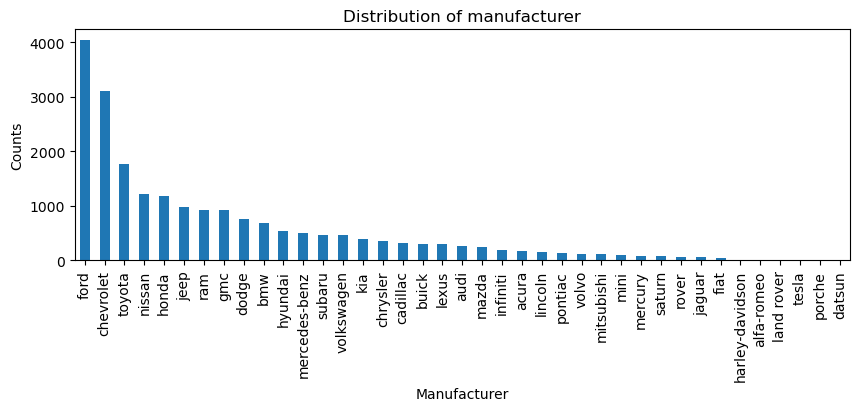

In [468]:
vehicles_df8 = vehicles_df7.copy()
plt.figure(figsize=(10,3))
vehicles_df8.manufacturer.value_counts().plot(kind="bar")
plt.title("Distribution of manufacturer")
plt.ylabel("Counts")
plt.xlabel("Manufacturer")
plt.show()

Ford is the Most Common Manufacturer with 4048 vehicles listed. This indicates that Ford vehicles are popular among consumers or that there is a larger variety of Ford models available compared to other manufacturers.

Imputation of missing values using the mode

In [469]:
mode_value = vehicles_df8['manufacturer'].mode()[0]  
vehicles_df8['manufacturer'].fillna(mode_value, inplace=True)

In [470]:
vehicles_df8.isnull().sum()

price             0
year              0
manufacturer      0
model           311
condition         0
cylinders         0
fuel              0
odometer          0
title_status      0
transmission      0
drive             0
type              0
paint_color       0
state             0
dtype: int64

**Handling of missing values for the variable "model"**

In [471]:
vehicles_df9 = vehicles_df8.copy()

**Imputation of type labels based on the most common model per manufacturer**

A mapping relationship will be established between manufacturers and the model of the car, and then assign
the most common model of the car corresponding to each manufacturer to the model field if it is NaN, 
based on the manufacturer assigned.

In [472]:
# Grouping by manufacturer and cylinders. Count the number of registries
df102 = vehicles_df9.groupby(["manufacturer","model"])["state"].count().reset_index()

# Group by manufaturer and extract the maximum value of the subgroup
max_values = df102.groupby(["manufacturer"])["state"].transform("max")

# Filter the data according to the max values
result = df102[df102['state'] == max_values]

# Build a dictionary containing manufacturer and cylinders.
manufacturer_dict = result.set_index('manufacturer')['model'].to_dict()

print(manufacturer_dict)
#df102.head(20)

{'acura': 'mdx', 'alfa-romeo': 'romeo stelvio', 'audi': 'a4', 'bmw': 'x5', 'buick': 'enclave', 'cadillac': 'escalade', 'chevrolet': 'silverado 1500', 'chrysler': '300', 'datsun': '260z', 'dodge': 'grand caravan', 'fiat': '500', 'ford': 'f-150', 'gmc': 'sierra 1500', 'harley-davidson': 'xl1200x sportster forty-eight', 'honda': 'civic', 'hyundai': 'sonata', 'infiniti': 'g37', 'jaguar': 'xf', 'jeep': 'wrangler', 'kia': 'soul', 'land rover': 'freelander', 'lexus': 'rx 350', 'lincoln': 'mkx', 'mazda': '3', 'mercedes-benz': 'c-class', 'mercury': 'grand marquis', 'mini': 'cooper', 'mitsubishi': 'outlander', 'nissan': 'altima', 'pontiac': 'grand prix', 'porche': 'cayenne', 'ram': '1500', 'rover': 'sport', 'saturn': 'vue', 'subaru': 'outback', 'tesla': 'model s', 'toyota': 'camry', 'volkswagen': 'jetta', 'volvo': 's60'}


In [473]:
vehicles_df9.model.fillna("",inplace=True)

Imputation of missing value in column "model"

In [474]:
vehicles_df9["model"] = vehicles_df9.apply(lambda x: asigncylinder(manufacturer_dict,x,"manufacturer","model"),axis=1)

Number of remaining missing values

In [475]:
vehicles_df9.model.isnull().sum()

0

**Balance of the Missing Values Reduction Process**

In [476]:
vehicles_df9.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

## Imbalance inside cathegorical variables  <a name="imbalance"></a>

In [477]:
vehicles_df10 = vehicles_df9.copy()

**Removing predictor variable due to low discriminatory power**

When a categorical variable is overwhelmingly dominated by a single category, its discriminatory power diminishes significantly. While there isn't a universally applicable threshold, it's commonly accepted that when one category encompasses over 90% or 95% of the observations, the variable's utility is greatly diminished. In such cases, removing the predictor becomes a suitable solution.

For instance:

1. **"title_status"**: The category "clean" commands a staggering 95.7% dominance.
2. **"transmission"**: "Automatic" claims a substantial 88.6% share.
3. **"fuel"**: "Gas" holds sway over 87% of the data.

Such imbalances among categories can trigger various issues, including biased model training and poor generalization.

In [478]:
vehicles_df10.drop(["title_status","transmission","fuel"],axis=1,inplace=True)

### FEATURE ENGINEERING   <a name="feature_engineering"></a>

In [515]:
vehicles_df_fe = vehicles_df10.copy()

When the category distribution inside a cathegorical variable is not dominated by one category, it is also important to adress imbalance if it exits. In this way, the robustness and accuracy of the model can be improved, ensuring that they perform well across all categories. 

**Variable "year"**  

The year of a model of a car is typically considered categorical because it represents a discrete category or group rather than a continuous numeric value

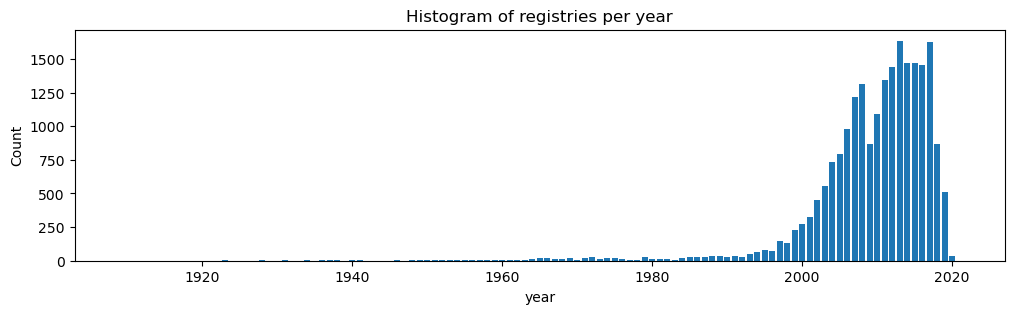

In [516]:
plt.figure(figsize=(12,3))
dfyear = vehicles_df_fe.year.value_counts().reset_index().sort_values(by="year")
plt.title("Histogram of registries per year")
plt.bar(dfyear.year, dfyear["count"])
plt.ylabel("Count")
plt.xlabel("year")
plt.show()

Categorize the years into different groups and justify the grouping:

1. **Older Than 2000**: These are cars manufactured before the year 2000. They have a significant price range, starting from 1000 and going up to 35900. Since they are older models, their prices tend to vary widely based on factors such as condition, mileage, and rarity.

2. **2000 - 2004**: This period covers the early 2000s. Prices during this time range from 1000 to 33500. Cars from this era may be considered older but still relatively modern, and their prices reflect their age and condition.

3. **2005 - 2009**: These years represent mid-2000s to late-2000s models. Prices in this period range from 1000 to 36999. Cars from this period may still be in good condition, but their prices may vary based on factors like mileage and maintenance history.

4. **2010 - 2014**: This period includes cars from the early 2010s. Prices range from 1000 to 36999. These cars are relatively modern and may have more advanced features compared to older models, influencing their prices.

5. **2015 - 2019**: These years represent recent models from the mid-2010s to late-2010s. Prices range from 1000 to 37419. Cars from this period may have newer technology and features, which can affect their pricing.

6. **2020 - 2021**: These are the most recent models available in the dataset. Prices range from 1000 to 36988. Cars from these years are likely to have the latest technology and features, potentially commanding higher prices.

By categorizing the years into these groups, we can observe how prices vary across different periods and gain insights into the general trends in the automotive market over time.

In [517]:
def asignyearlabel(x):
    
    if x < 2000:
        return "before 2000"
    elif (x >= 2000) & (x <= 2004):
        return "2000-2004"
    elif (x >= 2005) & (x <= 2009):
        return "2005-2009"
    elif (x >= 2010) & (x <= 2014):
        return "2010-2014"
    elif (x >= 2015) & (x <= 2019):
        return "2015-2019"
    elif (x >= 2010):
        return "After 2020"
    
vehicles_df_fe['year_category'] = vehicles_df_fe.year.apply(lambda x: asignyearlabel(x))

**Variable "age"** 

the variable "age" provides valuable information about a car's condition, maintenance needs, and potential value, making it an important predictor in various contexts such as pricing models, risk assessment, and market analysis within the automotive industry.

Creating a variable "age" to reflect the elapsed time since the car's construction.



In [520]:
vehicles_df_fe["age"] = 2014 - vehicles_df_fe["year"]

Removing variable "year"

In [521]:
vehicles_df_fe.drop(["year"],axis=1,inplace=True)

**Variable "cylinder"**  

The imbalance in the distribution of cylinder counts could potentially affect the performance of predictive models trained on this data. Models might struggle to accurately predict less frequent categories due to the limited amount of training data available for those categories. 

In [522]:
vehicles_df_fe.cylinders.value_counts()

cylinders
8 cylinders     8038
4 cylinders     6990
6 cylinders     6585
5 cylinders      175
10 cylinders      62
3 cylinders       35
other             34
12 cylinders       7
Name: count, dtype: int64

**Minimizing imbalance by grouping some categories** 


Based on these characteristics, we can group the cylinder types as follows:

1. Group 1: Economy and Small Cars (2, 3, 4-Cylinder)
2. Group 2: Midsize and Larger Cars (5, 6-Cylinder)
3. Group 3: Performance and Luxury Cars (8, 10, 12-Cylinder)
4. Group 4: others

Sources:    
4 Cylinder vs 6 Cylinder - What's the Difference?"
https://cascadecollision.com/blog/4-cylinder-vs-6-cylinder-engine-whats-the-difference/#:~:text=The%20key%20things%20to%20keep,have%20a%204%2Dcylinder%20engine.

Engine Displacement and Performance" 
https://www.cati.ca/what-is-engine-displacement-5-facts-for-students-at-automotive-mechanic-schools/#:~:text=The%20Effect%20of%20Engine%20Displacement,engine%20to%20generate%20more%20power.

How little engines are taking over American cars in a big way
https://www.ctvnews.ca/autos/how-little-engines-are-taking-over-american-cars-in-a-big-way-1.6357466

**Definition of new cathegorical predictor based on the column cylinder.**

In [523]:
dictcylinder = dict()
dictcylinder["8 cylinders"] = "Performance and Luxury"
dictcylinder["10 cylinders"] = "Performance and Luxury"
dictcylinder["12 cylinders"] = "Performance and Luxury"

dictcylinder["5 cylinders"] = "Midsize and Larg"
dictcylinder["6 cylinders"] = "Midsize and Larg"

dictcylinder["3 cylinders"] = "Economy and Small"
dictcylinder["4 cylinders"] = "Economy and Small"

dictcylinder["other"] = "others"

Creation new predictor 

In [524]:
vehicles_df_fe["cylinders_g"] = vehicles_df_fe["cylinders"].apply(lambda x: dictcylinder[x])

New distribution

In [525]:
vehicles_df_fe.cylinders_g.value_counts()

cylinders_g
Performance and Luxury    8107
Economy and Small         7025
Midsize and Larg          6760
others                      34
Name: count, dtype: int64

Removing variable "cylinder"

In [526]:
vehicles_df_fe.drop(["cylinders"],axis=1,inplace=True)

**Variable odometer** <a name="odometer_cathegorical"></a>

Based on the preceding analysis, it's evident that the odometer variable exhibits a right-skewed distribution with outliers. Moreover, the likelihood of users specifying precise odometer values during car purchases is relatively low. Consequently, to address these issues, the variable's values will be categorized as follows:

1. Low Mileage: 0 - 30,000 miles
2. Moderate Mileage: 30,001 - 70,000 miles
3. High Mileage: 70,001 - 100,000 miles
4. Very High Mileage: 100,001 miles and above

These categorizations offer a straightforward method for classifying odometer readings into distinct ranges based on mileage levels.

In [527]:
def odometercat(x):
    if x <= 30000:
        return "Low"
    elif (x >= 30001) & (x <= 70000):
        return "Moderate"
    elif (x >= 70001) & (x <= 100000):
        return "High"
    else:
        return "Very High"

Bulding new cathegorical variable based on odometer ranges

In [528]:
vehicles_df_fe["odometer_cat"] = vehicles_df_fe.odometer.apply(lambda x: odometercat(x))

Printing new categories

In [529]:
vehicles_df_fe.odometer_cat.value_counts()

odometer_cat
Very High    8511
High         7371
Moderate     3868
Low          2176
Name: count, dtype: int64

Removing old odometer variable

In [530]:
vehicles_df_fe.drop(["odometer"],axis=1,inplace=True)

## Data Analysis  <a name="data_analysis"></a>

### Discriminatory power  <a name="discriminatory_power"></a>

In [531]:
def rsquaredcalculation(df,category,target,is_cat):
    
    #inputs
    # df = dataframe with the values
    # category : label with the name of the column in dataframe
    # target   : label with the name of the dependent variables.
    # is_cat   : (False/True) indicates whether the predictor variable (category) is cathegorical or not.
    
    
    # Separate target variable and predictor variable
    X = df[[category]]  # Predictor variable (categorical)
    y = df[target]  # Target variable (continuous)

    # Define column transformer to perform one-hot encoding
    column_transformer = ColumnTransformer(
        transformers=[
            ('encoder', OneHotEncoder(), [category])
        ],
        remainder='passthrough'
    )

    # Define linear regression model
    model = LinearRegression()

    if is_cat == True:
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('model', model)
        ])

        # Fit the pipeline to the data
        pipeline.fit(X, y)

        # Make predictions
        predictions = pipeline.predict(X)
    else:
        model.fit(X, y)
        predictions = model.predict(X)
        
    # Calculate R-squared value
    r_squared = r2_score(y, predictions)
    return r_squared



**Calculating R-square values assuming a linear relationship between each predictor with the target variable**

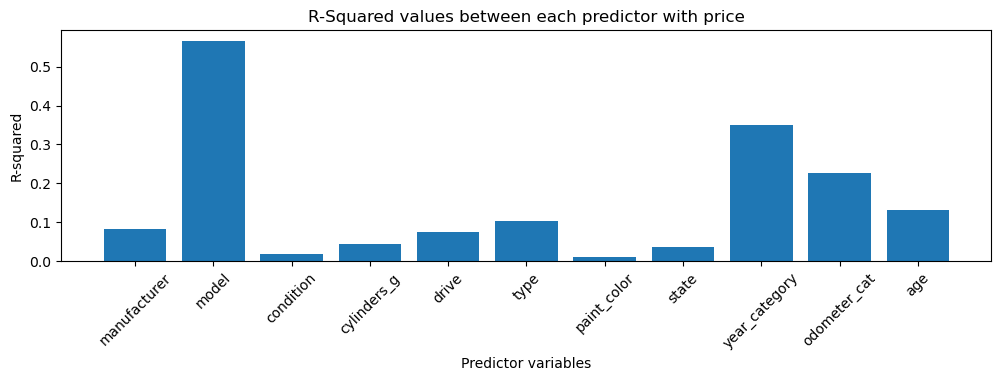

In [532]:
#Categorical variables 
listcat = ["manufacturer","model","condition","cylinders_g","drive","type", \
           "paint_color","state","year_category","odometer_cat"]

dictvar = dict()
for varcat in listcat:
    dictvar[varcat] = rsquaredcalculation(vehicles_df_fe,varcat,"price",True)

#Continuous variables
dictvar["age"] = rsquaredcalculation(vehicles_df_fe,"age","price",False)

#Visualization
plt.figure(figsize=(12,3))
plt.title("R-Squared values between each predictor with price")
plt.bar(dictvar.keys(), dictvar.values())
plt.ylabel("R-squared")
plt.xlabel("Predictor variables")
plt.xticks(rotation=45)
plt.show()

R-squared scores

In [533]:
print(dictvar)

{'manufacturer': 0.08373845303568073, 'model': 0.5649056811734123, 'condition': 0.018629690341571692, 'cylinders_g': 0.045303376609514334, 'drive': 0.0755000156393758, 'type': 0.10253438165639794, 'paint_color': 0.011020725765414463, 'state': 0.03711667748497294, 'year_category': 0.3511813194549894, 'odometer_cat': 0.22642985910097957, 'age': 0.13187120859725798}


**Conclusions:**   

Regarding the potential linear relationship between the predictor and the target variable, the R-squared values reveal that the car's model stands out as the most impactful, exhibiting a robust association with car price, indicated by its highest R-squared value of 0.56. Additionally, the year of the model, the odometer, the age, the type and manufacturer demonstrate a moderate association at 0.38,0.22,0.13, 0.1025 and 0.083,respectively.  Conversely, other factors display weaker associations with car price.


### Modeling  <a name="modeling"></a>

In [535]:
vehicles_df_m = vehicles_df_fe[["price","model","age","odometer_cat","drive","year_category","type","manufacturer"]].copy()

**Adjusted price strategy**

When proposing a model to implement the adjusted price strategy,  machine learning algorithms that can handle regression tasks effectively and is capable of capturing complex relationships in the data are necessary. For example,  ensemble methods like Random Forest or Gradient Boosting, such as XGBoost or LightGBM. 

Important feature of the chosen models: 

1. **Ability to Capture Complex Relationships**: These algorithms can capture non-linear relationships and interactions between car features and prices, which is crucial for accurately predicting adjusted prices.
2. **Robustness to Outliers and Noise**: Ensemble methods are robust to outliers and noisy data, which is common in real-world datasets like car pricing data.


**Model LightGBM** <a name="lightgbm"></a>

Additionally to the last ones, LightGBM offers several advantages when dealing with categorical variables:

1. **Optimized Handling**: It internally converts categorical features into integer codes using techniques like 'Feature Parallel' and 'Histogram-based' methods, which can lead to faster training and better performance compared to other gradient boosting implementations.

2. **Improved Accuracy**: LightGBM's efficient handling of categorical variables can lead to improved model accuracy, especially when dealing with high-cardinality categorical features where traditional encoding methods may be less effective.



**Normalization of variables "age"**

In [536]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()

# Normalize age and odometer
vehicles_df_m['age'] = scaler.fit_transform(vehicles_df_m[['age']])


**Standarization of variable "model"** 

Removing accent and special characters

In [537]:
vehicles_df_m.model = vehicles_df_m.model.apply(lambda x: x.strip())
vehicles_df_m.model= vehicles_df_m.model.apply(lambda x: re.sub(r'[^\p{L}\p{N}\s]', '', x))
vehicles_df_m.model= vehicles_df_m.model.apply(lambda x: unidecode(x))
vehicles_df_m.model= vehicles_df_m.model.apply(lambda x: x.replace(" ","_"))


Defining cathegorical variables as categories for lightGBM

In [538]:
vehicles_df_m.model = vehicles_df_m.model.astype('category')
vehicles_df_m.drive = vehicles_df_m.drive.astype('category')
vehicles_df_m.odometer_cat = vehicles_df_m.odometer_cat.astype("category")
vehicles_df_m.manufacturer = vehicles_df_m.manufacturer.astype("category")
vehicles_df_m["type"] = vehicles_df_m["type"].astype("category")
vehicles_df_m.year_category = vehicles_df_m.year_category.astype('category')
vehicles_df_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21926 entries, 0 to 26987
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21926 non-null  int64   
 1   model          21926 non-null  category
 2   age            21926 non-null  float64 
 3   odometer_cat   21926 non-null  category
 4   drive          21926 non-null  category
 5   year_category  21926 non-null  category
 6   type           21926 non-null  category
 7   manufacturer   21926 non-null  category
dtypes: category(6), float64(1), int64(1)
memory usage: 838.7 KB


**Implementation of model training**

In [539]:
#vehicles_df_m = vehicles_df_m[0:20000]
vehicles_df_m.shape

(21926, 8)

**Training and test set**

In [540]:
X = vehicles_df_m.drop(columns=['price'])
y = vehicles_df_m['price']

In [541]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM dataset
#train_data = lgb.Dataset(X_train, label=y_train)
#test_data = lgb.Dataset(X_test, label=y_test)

**Gridsearch for hyperparameter tunning** <a name="grid_search"></a>

In [230]:
# Define parameter grid
param_grid = {
     'objective': ['regression'],
    'boosting_type': ['gbdt','dart'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [-1, 3, 5],
    'verbosity': [-1],
    'cat_l2': [4,10,16],  # L2 regularization for categorical features
    'cat_smooth': [4,10,16],  # smoothing parameter for categorical features
    'bagging_freq': [5,10,15],
    'lambda_l1': [0.1,0.01,0.001],  # L1 regularization
    'lambda_l2': [0.1,0.01,0.001]  # L2 regularization
    # Add other parameters to tune
}

# Perform grid search
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

{'bagging_freq': 5, 'boosting_type': 'gbdt', 'cat_l2': 4, 'cat_smooth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 31, 'objective': 'regression', 'verbosity': -1}


**Prediction with optimized parameters**

In [542]:
# Define parameters for LightGBM
params = {
    'objective': 'regression',  # for regression tasks
    'metric': 'mse',  # mean squared error as the evaluation metric
    'boosting_type': 'gbdt',  # gradient boosting decision tree
    'num_leaves': 31,  # maximum number of leaves in one tree
    'learning_rate': 0.1,  # learning rate
    'feature_fraction': 0.8,  # randomly select a subset of features
    'bagging_fraction': 0.8,  # randomly select a subset of data
    'bagging_freq': 5,  # perform bagging at every 5 iterations
    'max_depth': 5,  # no limit on the maximum depth of trees
    'lambda_l1': 0.1,  # L1 regularization
    'lambda_l2': 0.1,  # L2 regularization
    'cat_l2': 4,  # L2 regularization for categorical features
    'cat_smooth': 4,  # smoothing parameter for categorical features
    'verbosity': -1  # silent mode
}

# Create and train LGBMRegressor model
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)



LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, cat_l2=4, cat_smooth=4,
              feature_fraction=0.8, lambda_l1=0.1, lambda_l2=0.1, max_depth=5,
              metric='mse', objective='regression', verbosity=-1)

**Validation of training and testing**

In [543]:
# Make predictions
y_pred = model.predict(X_test)

# Make predictions
y_pred_train = model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: test", mse)


Mean Squared Error train: 17645642.91038281
Mean Squared Error: test 21207401.764878113


### Results  <a name="results"></a>

**Visualization of mapping between actual prices and predicted prices in the training set** <a name="actual_vs_predicted"></a>

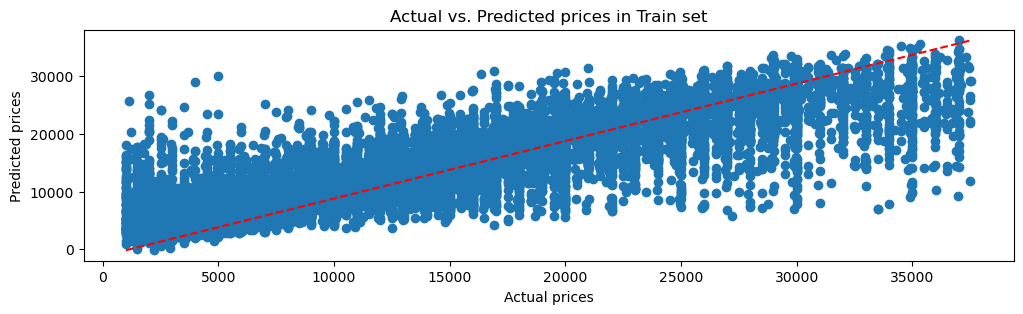

In [544]:
# Actual vs. Predicted plot
plt.figure(figsize=(12, 3))
plt.scatter(y_train, y_pred_train)
plt.plot([min(y_train), max(y_train)], [min(y_pred_train), max(y_pred_train)], '--', color='red')  # diagonal line
plt.title('Actual vs. Predicted prices in Train set')
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices')
plt.show()

**Q-Q plot** 

Q-Q plots are often used to check if a dataset follows a specific theoretical distribution 
If the points align closely with the diagonal line, it suggests that the dataset follows that distribution.

Interpretation: 
    
If the points are above the diagonal line, it indicates that the dataset being tested has higher values than the reference dataset at those quantiles.
If the points are below the diagonal line, it suggests that the dataset being tested has lower values than the reference dataset at those quantiles.

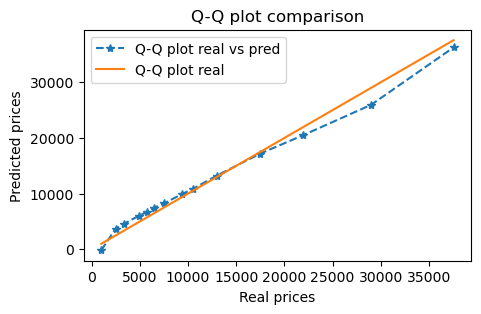

In [545]:
# Define the percentiles you want to calculate
percentiles = [0, 0.05, 0.10, 0.20, 0.25,0.30, 0.35,0.45, 0.50,0.60, 0.75,0.85,0.95, 1]  # List of percentiles from 0 to 100

plt.figure(figsize=(5,3))
plt.title("Q-Q plot comparison")
# Calculate the percentiles using the quantile() method
resultreal = y_train.quantile(percentiles)
resultpred = pd.Series(y_pred_train).quantile(percentiles)
plt.plot(resultreal,resultpred, label="Q-Q plot real vs pred", marker="*", linestyle="--")
plt.plot(resultreal, resultreal, label="Q-Q plot real ")
plt.xlabel("Real prices")
plt.ylabel("Predicted prices")
plt.legend()
plt.show()

The examination of the Q-Q plot in training set for both actual and predicted prices indicates that the predictive model tends to overestimate prices below 15000 and underestimate prices above 15000 to a significantly larger extent.

**Visualization of mapping between actual prices and predicted prices in the test set**

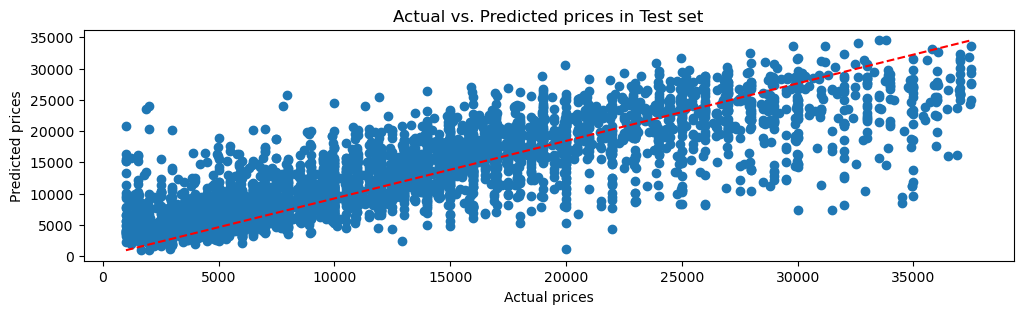

In [546]:
# Actual vs. Predicted plot
plt.figure(figsize=(12, 3))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], '--', color='red')  # diagonal line
plt.title('Actual vs. Predicted prices in Test set')
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices')
plt.show()

**Q-Q plot in test set**

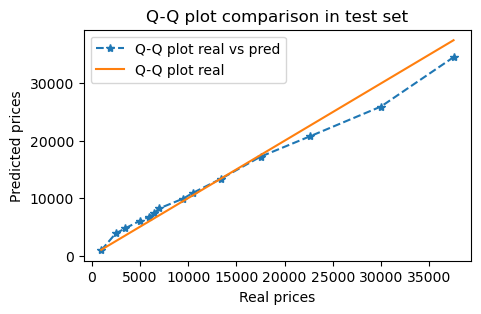

In [547]:
# Define the percentiles you want to calculate
percentiles = [0, 0.05, 0.10, 0.20, 0.25,0.30, 0.35,0.45, 0.50,0.60, 0.75,0.85,0.95, 1]  # List of percentiles from 0 to 100

plt.figure(figsize=(5,3))
plt.title("Q-Q plot comparison in test set")
# Calculate the percentiles using the quantile() method
resultreal = y_test.quantile(percentiles)
resultpred = pd.Series(y_pred).quantile(percentiles)
plt.plot(resultreal,resultpred, label="Q-Q plot real vs pred", marker="*", linestyle="--")
plt.plot(resultreal, resultreal, label="Q-Q plot real ")
plt.xlabel("Real prices")
plt.ylabel("Predicted prices")
plt.legend()
plt.show()

The examination of the Q-Q plot in test set for both actual and predicted prices indicates that
the predictive model tends to overestimate prices below 15000 and underestimate prices above 15000 to a significantly larger extent.

**Distribution of residuals**  <a name="residuals"></a>

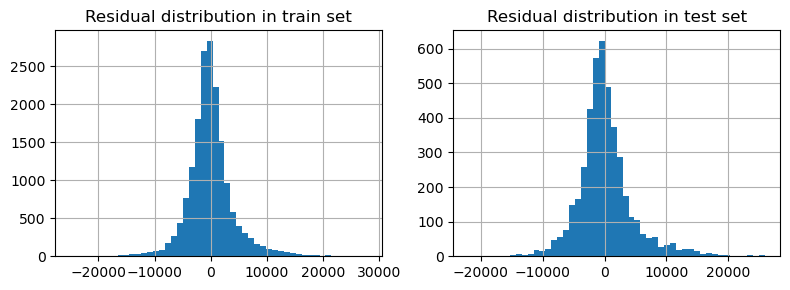

In [548]:
residual_test = y_test-y_pred
residual_train = y_train - y_pred_train

plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first diagram
pd.Series(residual_train).hist(bins=50)
plt.title('Residual distribution in train set')

# Create the second diagram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second diagram
residual_test.hist(bins=50)
plt.title('Residual distribution in test set')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the diagrams
plt.show()

One anticipated outcome of modeling is the presence of normally distributed residuals. The distribution of residuals in both the training and test sets demonstrates this norm, affirming that the model assumptions hold true. Consequently, the model gains robustness, reducing the risk of bias or inefficiency. Deviations from normality often signal potential shortcomings, such as overlooked explanatory variables or inadequately captured relationships between variables.

**Adjustment of prices based on adjusted pricing strategy**  <a name="adjusted_prices_model">

In [549]:
# Set probability threshold for high probability of selling
probability_threshold = 0.8

In [550]:
# Function to calculate adjusted prices
def calculate_adjusted_prices(predicted_prices, market_values, probability_threshold):
    adjusted_prices = []
    for i in range(0,len(predicted_prices)):
        overcharge_ratio = predicted_prices[i] / market_values[i] - 1
        probability_of_sale = max(1 - min(1, overcharge_ratio), 0)
        if overcharge_ratio > 0 and probability_of_sale > probability_threshold:
            adjusted_prices.append(predicted_prices[i] * probability_of_sale)
        else:
            adjusted_prices.append(predicted_prices[i])
    return np.array(adjusted_prices)

**Prediction over the whole dataset**

In [551]:
model.fit(X, y)
y_pred_whole = model.predict(X)

Calculate adjusted prices for the whole dataset

In [552]:
# Calculate adjusted prices for training data
adjusted_prices_whole = calculate_adjusted_prices(y_pred_whole, y.to_list(), probability_threshold)
print(adjusted_prices_whole)

[ 3334.23656933  6131.99479189  6360.01397569 ... 12342.87878013
  3760.89333799 20892.05619187]


**Visualization of results supporting the adjusted price strategy**



In [553]:
# Sample predicted prices and adjusted prices
predicted_prices = np.array(y_pred_whole)
adjusted_prices = np.array(adjusted_prices_whole)
market_values = y.values

predicted_serie = pd.Series(predicted_prices)
adjusted_serie = pd.Series(adjusted_prices_whole)

**Calculation of overcharge, probability, profit and losses of saling for the adjusted prices**

In [554]:
df888 = pd.DataFrame()
df888["price"] = y.values
df888["predicted_prices"] = predicted_serie
df888["adjusted_prices"] = adjusted_serie

# Overcharge for the predicted prices
df888["overcharge_pred"] = df888.predicted_prices / df888.price  -1 

# Probability of sale for the predicted prices
df888["prob_sale_pred"] =  1 - df888.overcharge_pred.apply(lambda x: x if x < 1 else 1)
#df888["prob_sale_pred"] = df888["prob_sale_pred"].apply(lambda x : x if x > 0 else 0)

# Overcharge for the adjusted prices
df888["overcharge_adj"] = df888.adjusted_prices / df888.price  -1 

# Probability of sale for the adjusted prices
df888["prob_sale_adj"] =  1 - df888.overcharge_adj.apply(lambda x: x if x < 1 else 1)
#df888["prob_sale_adj"] = df888["prob_sale_adj"].apply(lambda x : x if x > 0 else 0)

# Profit for the predicted prices
df888["profit_pred"] = df888.predicted_prices - df888.price
df888["profit_pred"] = df888.profit_pred.apply(lambda x : x if x > 0 else 0)

#Profit for the adjusted prices
df888["profit_adj"] = df888.adjusted_prices - df888.price
df888["profit_adj"] = df888.profit_adj.apply(lambda x : x if x > 0 else 0)

#Loss for the predicted prices
df888["loss_pred"] = df888.predicted_prices - df888.price
df888["loss_pred"] = df888.loss_pred.apply(lambda x : x if x < 0 else 0)

#Los for the adjusted prices
df888["loss_adj"] = df888.adjusted_prices - df888.price
df888["loss_adj"] = df888.loss_adj.apply(lambda x : x if x < 0 else 0)


**Visualizing change in profit and loss** <a name="profit_loss"></a>

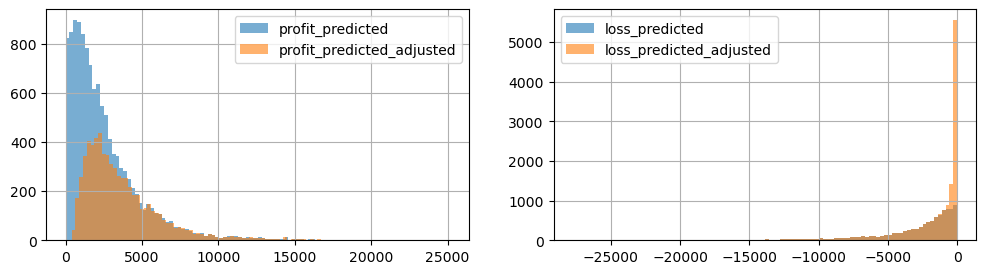

In [557]:
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
df8888 = df888.copy()
df88881 = df8888[df8888.profit_pred > 0]
df88882 = df8888[df8888.profit_adj > 0]
df88881.profit_pred.hist(bins=100,alpha=0.6,label="profit_predicted")
df88882.profit_adj.hist(bins=100,alpha=0.6,label="profit_predicted_adjusted")
plt.legend()

plt.subplot(1, 2, 2)
df8882 = df888.copy()
df88821 = df8882[df8882.loss_pred < 0]
df88822 = df8882[df8882.loss_adj < 0]
df88821.loss_pred.hist(bins=100,label="loss_predicted",alpha=0.6)
df88822.loss_adj.hist(bins=100,label="loss_predicted_adjusted",alpha=0.6)
plt.legend()
plt.show()


**Q-Q plot probability of saling**  <a name="pro_of_saling"></a>

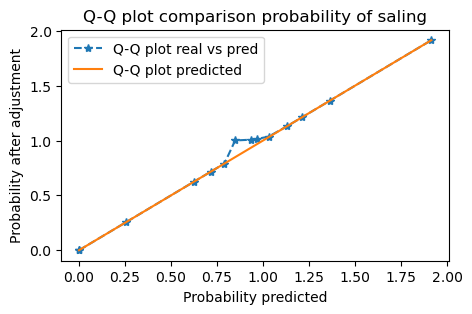

In [568]:
# Define the percentiles you want to calculate
percentiles = [0, 0.05, 0.10, 0.20, 0.25,0.30, 0.35,0.45, 0.50,0.60, 0.75,0.85,0.95, 1]  # List of percentiles from 0 to 100

plt.figure(figsize=(5,3))
plt.title("Q-Q plot comparison probability of saling")
# Calculate the percentiles using the quantile() method
prob_adj = df888.prob_sale_adj.quantile(percentiles)
prob_pred = df888.prob_sale_pred.quantile(percentiles)
plt.plot(prob_pred ,prob_adj, label="Q-Q plot real vs pred", marker="*", linestyle="--")
plt.plot(prob_pred , prob_pred , label="Q-Q plot predicted ")
plt.xlabel("Probability predicted")
plt.ylabel("Probability after adjustment")
plt.legend()
plt.show()

The likelihood of selling for both the predicted and adjusted prices exhibits a similar distribution, indicating comparable probabilities. However, the adjusted prices show a notable rise in the probability of sales. This suggests that while the general trend remains consistent, adjustments to pricing have significantly enhanced the likelihood of successful sales.

## QUESTIONS ASIGNED <a name="asigned_question"></a>

Data Analysis
During your analysis we would like you to answer the following questions:
Take each of the following 3 variables:
• odometer
• condition
• vin
For each of them analyze the following points:
1. Evaluate the completeness of the variable and highlight any findings
you think relevant for a discussion.
2. Evaluate how well the value discriminates your dependent variable
and determine if you would use it in your model.
3. If the previous answer was affirmative then how would you propose to
include it in your model. That is, what transformations, techniques,
or tools would you use to include it.
Are there any duplicate, redundant or irrelevant variables in your data
set? If there are, how would you deal with them?

### Odometer:  <a name="variable_odometer_a"></a>

Based on the statistics provided for the variable "odometer," it appears that the data is positively skewed, as indicated by a mean larger than the median. Given this skewness and the influence of outliers, it is appropiate to impute missing values or handle outliers using the median rather than the mean. The median is less affected by extreme values and provides a more robust measure of central tendency in such cases.

It is also important to take into consideration, that the precision of odometer readings provided by users during car purchases is relatively low. Because of that, a numeric representation of the odometer variable is not adecuate.  To address these issues, the variable's values can be categorized into distinct mileage ranges:

1. Low Mileage: 0 - 30,000 miles
2. Moderate Mileage: 30,001 - 70,000 miles
3. High Mileage: 70,001 - 100,000 miles
4. Very High Mileage: 100,001 miles and above

These categorized ranges offer a practical approach for classifying odometer readings based on different mileage levels.

Subsequently, the variable "odometer_cat" was created. The distribution indicates that a significant portion of vehicles falls within the "Very High" and "High" mileage categories, suggesting that many cars have accumulated considerable mileage.

Furthermore, the variable "odometer" exhibits a 0.22 R-squared value in relation to the price variable. This indicates that approximately 22% of the variability in price can be explained by the odometer readings, suggesting a moderate level of association between mileage and price.

### Condition: <a name="variable_condition_a"></a>

Based on the previous process:

The variable "condition" has a relatively low percentage of missing values, approximately 4.02%. This suggests that most of the data for this variable is available, which is beneficial for analysis.

The variable "condition" has several categories indicating the condition of the vehicles listed. These categories range from "excellent" and "good" to "like new," "fair," "new," and "salvage." The distribution shows that "excellent" and "good" are the most common conditions listed, followed by "like new," "fair," "new," and "salvage."

The categories "excellent," "good," and "like new" suggest varying degrees of vehicle quality, with "excellent" indicating the highest quality and "like new" suggesting a premium quality comparable to a new vehicle. To simplify analysis and address missing values, the categories will be grouped as follows:
   - "Excellent" and "good" will be grouped as "good condition" (the most frequent category).
   - "Like new" and "new" will be grouped as "like new or new."
   - "Fair" and "salvage" will remain as separate categories.

To handle missing values, imputation with the mode (most frequent category) will be applied. This ensures that missing values are replaced with the most common condition category, which is "good condition" in this case. After imputation, the distribution of condition categories shows that the majority of vehicles are classified as being in "good condition," followed by "like new or new," "fair," and "salvage."

On the other side, the variable "condition" has a relatively low R-squared value of approximately 0.0186 in relation to the price variable. This indicates that only about 1.86% of the variability in price can be explained by the condition of the vehicles. Thus, while condition may have some influence on price, other factors likely play a more significant role in determining the price of a vehicle.

### VIN (Vehicle Identification Number):  <a name="variable_vin_a"></a>

Based on the previous analysis:

The dataset contains 1307 duplicated Vehicle Identification Numbers (VINs), indicating that there are multiple entries for the same vehicles within the dataset. Duplicate rows, particularly those based on VINs, are being removed from the dataset. This decision is justified for the following reasons:

1. Uniqueness: VINs are unique identifiers assigned to individual vehicles. Including duplicate VINs in the dataset does not provide meaningful information for predicting car prices, as each VIN corresponds to a specific car and does not contain inherent characteristics related to price prediction.

2. Non-Predictive: VINs are not predictive of car prices themselves. While VINs are essential for purposes such as vehicle registration and tracking, they do not directly influence the price of a car.

By removing duplicate rows based on VINs, the dataset is streamlined and cleaned, ensuring that each vehicle is represented only once. This enhances the accuracy and reliability of any subsequent analysis or modeling performed using the dataset.


### Discriminatory power 

here are the conclusions related:

1. **Removing Predictor Variables with Low Discriminatory Power**:
   - When a categorical variable is overwhelmingly dominated by a single category, its ability to discriminate or provide useful information diminishes.
   - In cases where one category encompasses over 90% or 95% of the observations, the variable's usefulness for prediction decreases significantly.
   - For example, variables like "title_status," "transmission," and "fuel" have one dominant category that accounts for a substantial majority of the data.
   - Such imbalances can lead to biased model training and poor generalization, so removing these predictors is a suitable solution.

2. **Relevance for Prediction of Latitude, Longitude, and Description Columns**:
   - Latitude and longitude coordinates represent geographic location, which is already indicated through the "State" and "Region" columns. Including them as predictor variables may not provide meaningful insights for price prediction.
   - Car descriptions are subjective and unstructured, and including them in the dataset increases complexity without necessarily improving model accuracy. Removing them streamlines the dataset.

3. **Removing the "Region" Column**:
   - The decision to exclude the "Region" variable is based on the specific goals of the model.
   - In this context, the focus is on precisely forecasting prices across diverse regulatory landscapes rather than capturing general market trends, which can be highly variable over time.
   - Additionally, incorporating both "State" and "Region" could overly complicate the model and reduce its practical utility.

Overall, by removing these variables with low discriminatory power and limited relevance for prediction, the dataset becomes more focused and better suited for accurate price prediction modeling.

### Target Variable "price" <a name="variable_price_a"></a>

The list of car prices encompasses a diverse range of values, with an average price of approximately 55,116 units. The notable standard deviation of around 6,795,834 suggests considerable variability, indicating that prices vary significantly from this average. While most cars are priced within a reasonable range, outliers exist, exemplified by the minimum price of 0 and the maximum of approximately 1,116,081,000. Furthermore, quartile analysis reveals that three-quarters of prices fall below 17,900, offering insights into the distribution of prices among the listed cars. However, 25% of prices are below 4,250.

When considering the legal framework surrounding car sales, jurisdictions vary in their regulations. While some areas may lack specific legal minimum values for car sales, laws governing fair and transparent transactions are commonplace. For instance, regulations governing the sale of used cars may exist to prevent predatory pricing or unfair practices, potentially setting minimum prices for vehicles.

Regarding missing price information, a significant portion of the dataset, approximately 8.50%, lacks pricing details. Imputing missing values is a common approach but poses several drawbacks, including bias introduction, overfitting, data leakage, reduced model interpretability, and potential loss of information. Given the absence of substantial real-world car prices below 1,000 units, it may be assumed that this represents a minimum legal price for a car. Consequently, in this context, removing rows with missing prices could be preferable to imputing values, as imputation may introduce bias or inaccuracies into the model.

Lastly, the removal of outliers using the Interquartile Range (IQR) method is considered. This is motivated by the desire to maintain model performance, uphold assumptions of normality, and improve the robustness and generalization ability of the predictive model. Approximately 3.78% of the dataset is identified as outliers, warranting their removal to enhance model validity and statistical interpretations.

### MODEL <a name="model_a"></a>


1. **Model Performance:** The model's performance, evaluated using mean squared error, indicates how accurately it predicts prices. While it performs reasonably well on data it was trained on, it doesn't perform as well on new, unseen data. This suggests that the model might struggle with accurately predicting prices for cars it hasn't encountered before.

2. **Prediction Patterns:** When comparing actual prices to those predicted by the model, a consistent pattern emerges. It tends to overestimate prices for lower-priced cars and underestimate prices for higher-priced ones. This pattern should be taken into account when relying on the model's predictions, as it may affect decision-making.

3. **Residuals Analysis:** A positive aspect of the model is that the differences between actual and predicted prices, known as residuals, follow a normal distribution. This means that the model's assumptions are valid, and it's less likely to produce biased or inefficient predictions. It provides more confidence in the reliability of the model's output.

4. **Likelihood of Sales:** The likelihood of selling for both the predicted and adjusted prices shows similar distributions, indicating comparable probabilities. However, when prices are adjusted, there is a noticeable increase in the probability of sales. This suggests that adjusting prices can significantly improve the chances of a successful sale, while still maintaining consistency with the overall trend.